In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import librosa.display
import sys
import time

In [2]:
def normalize_features(features):
    mean = np.mean(features, axis=0)
    std = np.std(features, axis=0) + 1e-10
    return (features - mean) / std

In [3]:
def phoneme_transform(features):
    transformed = np.copy(features)
    transformed[:, 0] = np.mean(transformed[:, 0])  # Example transformation
    return transformed

In [4]:
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T
    mfccs = normalize_features(mfccs)
    mfccs = phoneme_transform(mfccs)
    return mfccs

In [5]:
def dtw_distance(template, sample):
    if len(template) == 0 or len(sample) == 0:
        return float('inf')

    template = normalize_features(template)
    sample = normalize_features(sample)

    n, m = len(template), len(sample)
    cost_matrix = np.zeros((n + 1, m + 1))
    cost_matrix[0, 1:] = np.inf
    cost_matrix[1:, 0] = np.inf
    cost_matrix[0, 0] = 0

    for i in range(1, n + 1):
        for j in range(1, m + 1):
            cost = np.linalg.norm(template[i-1] - sample[j-1])
            prev_cost = min(cost_matrix[i-1, j], cost_matrix[i-1, j-1], cost_matrix[i, j-1])
            cost_matrix[i, j] = cost + prev_cost

    return cost_matrix[n, m] / (n + m)

In [6]:
def detect_keyword_in_file(audio_file_path, keyword_file_path, threshold=0.4, window_size_factor=2, step_size=5):
    keyword_features = extract_features(keyword_file_path)
    keyword_len = len(keyword_features)

    y, sr = librosa.load(audio_file_path, sr=16000)
    audio_duration = librosa.get_duration(y=y, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20).T
    features = normalize_features(mfccs)
    features = phoneme_transform(features)

    print(f"Audio duration: {audio_duration:.2f}s | Feature shape: {features.shape}")
    window_size = min(keyword_len * window_size_factor, len(features))

    detections = []
    all_distances = []
    total_steps = range(0, len(features) - keyword_len + 1, step_size)

    for idx, i in enumerate(total_steps):
        sequence = features[i:i+keyword_len]
        distance = dtw_distance(keyword_features, sequence)
        all_distances.append(distance)

        progress = (idx + 1) / len(total_steps)
        bar = '█' * int(progress * 40) + '-' * (40 - int(progress * 40))
        sys.stdout.write(f'\rScanning |{bar}| {int(progress * 100)}%')
        sys.stdout.flush()

        if distance < threshold:
            time_sec = i * audio_duration / len(features)
            if not detections or time_sec - detections[-1] > 0.5:
                detections.append(time_sec)
                print(f"\nKeyword detected at {time_sec:.2f}s (distance: {distance:.4f})")

    print()

    # Plot distances
    plt.figure(figsize=(15, 5))
    plt.plot(np.linspace(0, audio_duration, len(all_distances)), all_distances)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold})')
    plt.title('DTW Distances')
    plt.xlabel('Time (s)')
    plt.ylabel('Distance')
    plt.legend()
    plt.show()

    return detections

In [8]:
def visualize_sentence_waveform(audio_file_path):
    y, sr = librosa.load(audio_file_path, sr=16000)
    duration = librosa.get_duration(y=y, sr=sr)
    plt.figure(figsize=(12, 6))

    # Waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Sentence Waveform ({duration:.2f} sec)')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # Spectrogram
    plt.subplot(2, 1, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency')
    plt.tight_layout()
    plt.show()

In [7]:
def visualize_detections(audio_file_path, detections):
    y, sr = librosa.load(audio_file_path, sr=16000)

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Waveform with Keyword Detections')
    for detection in detections:
        plt.axvline(x=detection, color='r', linestyle='--')

    plt.subplot(2, 1, 2)
    S = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), y_axis='mel', x_axis='time')
    plt.title('Spectrogram with Keyword Detections')
    for detection in detections:
        plt.axvline(x=detection, color='r', linestyle='--')

    plt.tight_layout()
    plt.show()

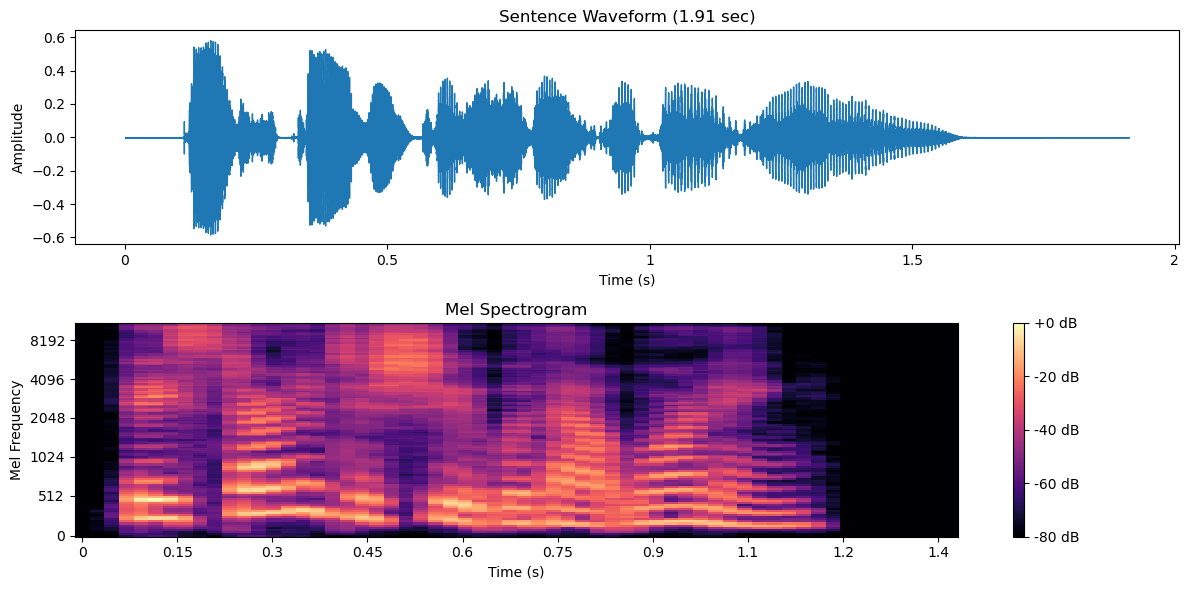

Audio duration: 1.91s | Feature shape: (60, 20)
Scanning |████████████████████████████████████████| 100%


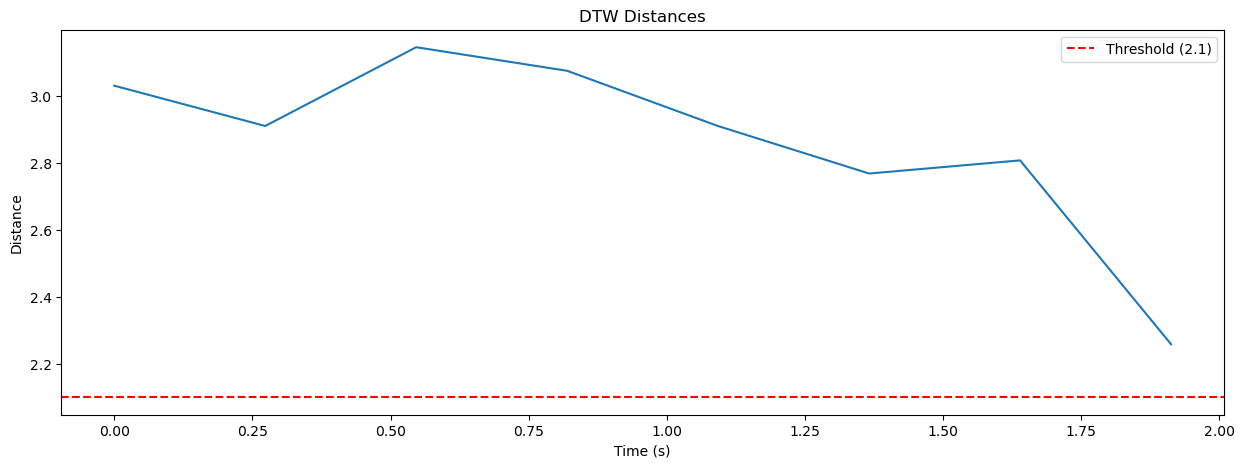

[]


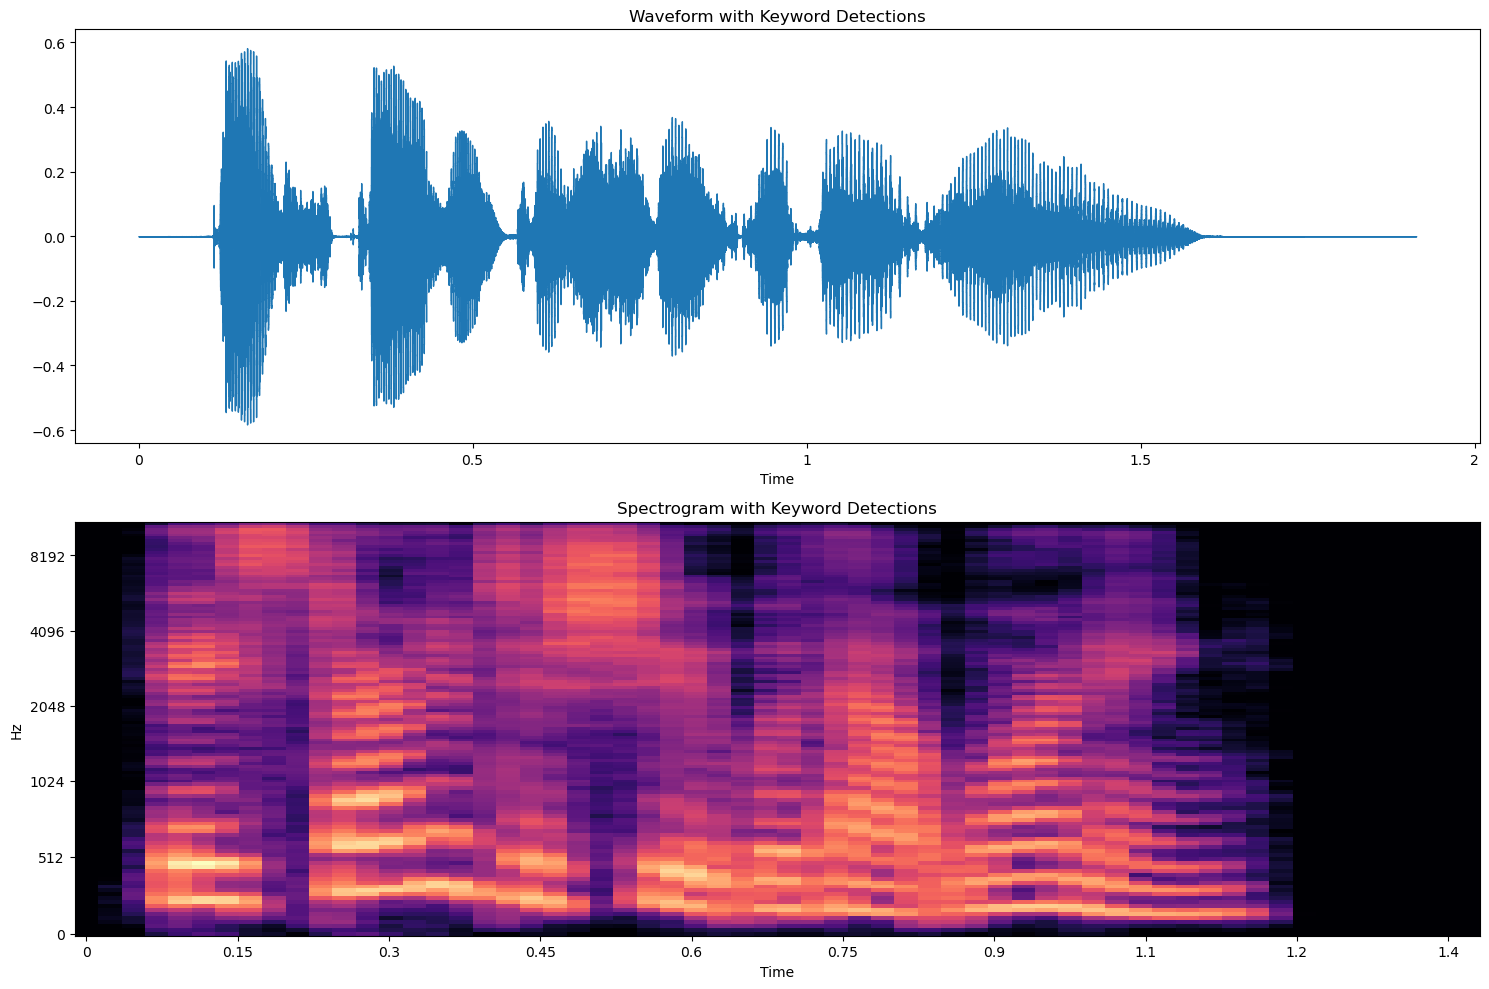

In [16]:
sentence_path = r"C:\Users\hp\Downloads\They started to shoo.wav"
visualize_sentence_waveform(sentence_path)

detections = detect_keyword_in_file(sentence_path,r"C:\Users\hp\Downloads\kill.wav", threshold=2.1)
print(detections)
visualize_detections(sentence_path, detections)

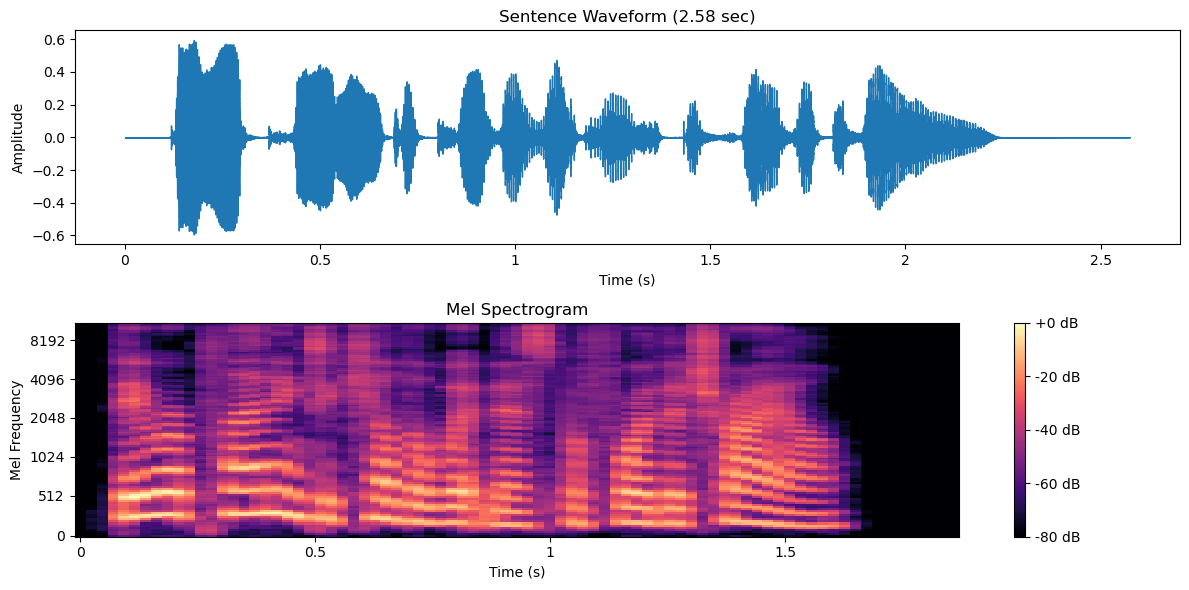

Audio duration: 2.58s | Feature shape: (81, 20)
Scanning |████████████████████████████████████████| 100%
Keyword detected at 1.75s (distance: 1.8725)



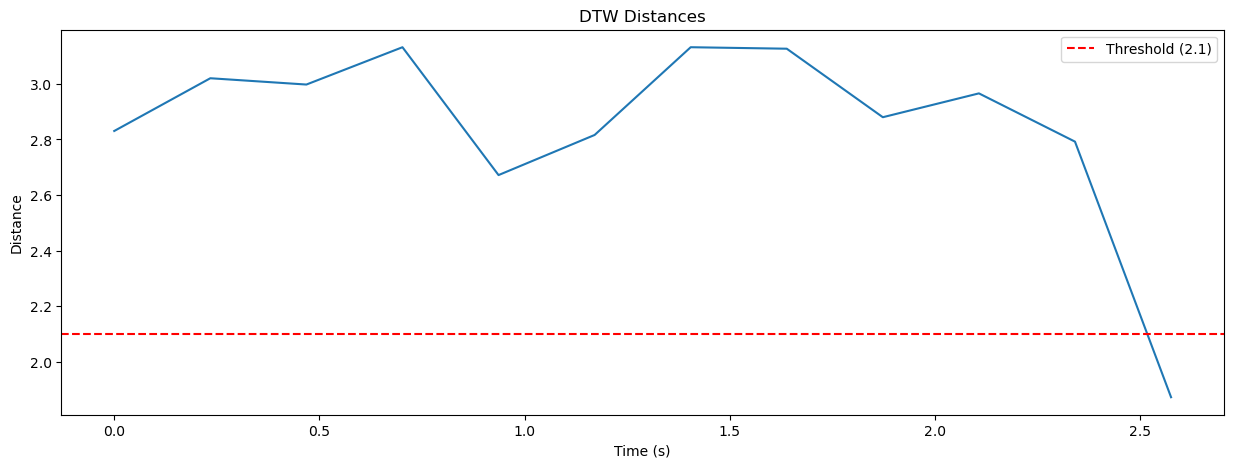

[1.748456790123457]


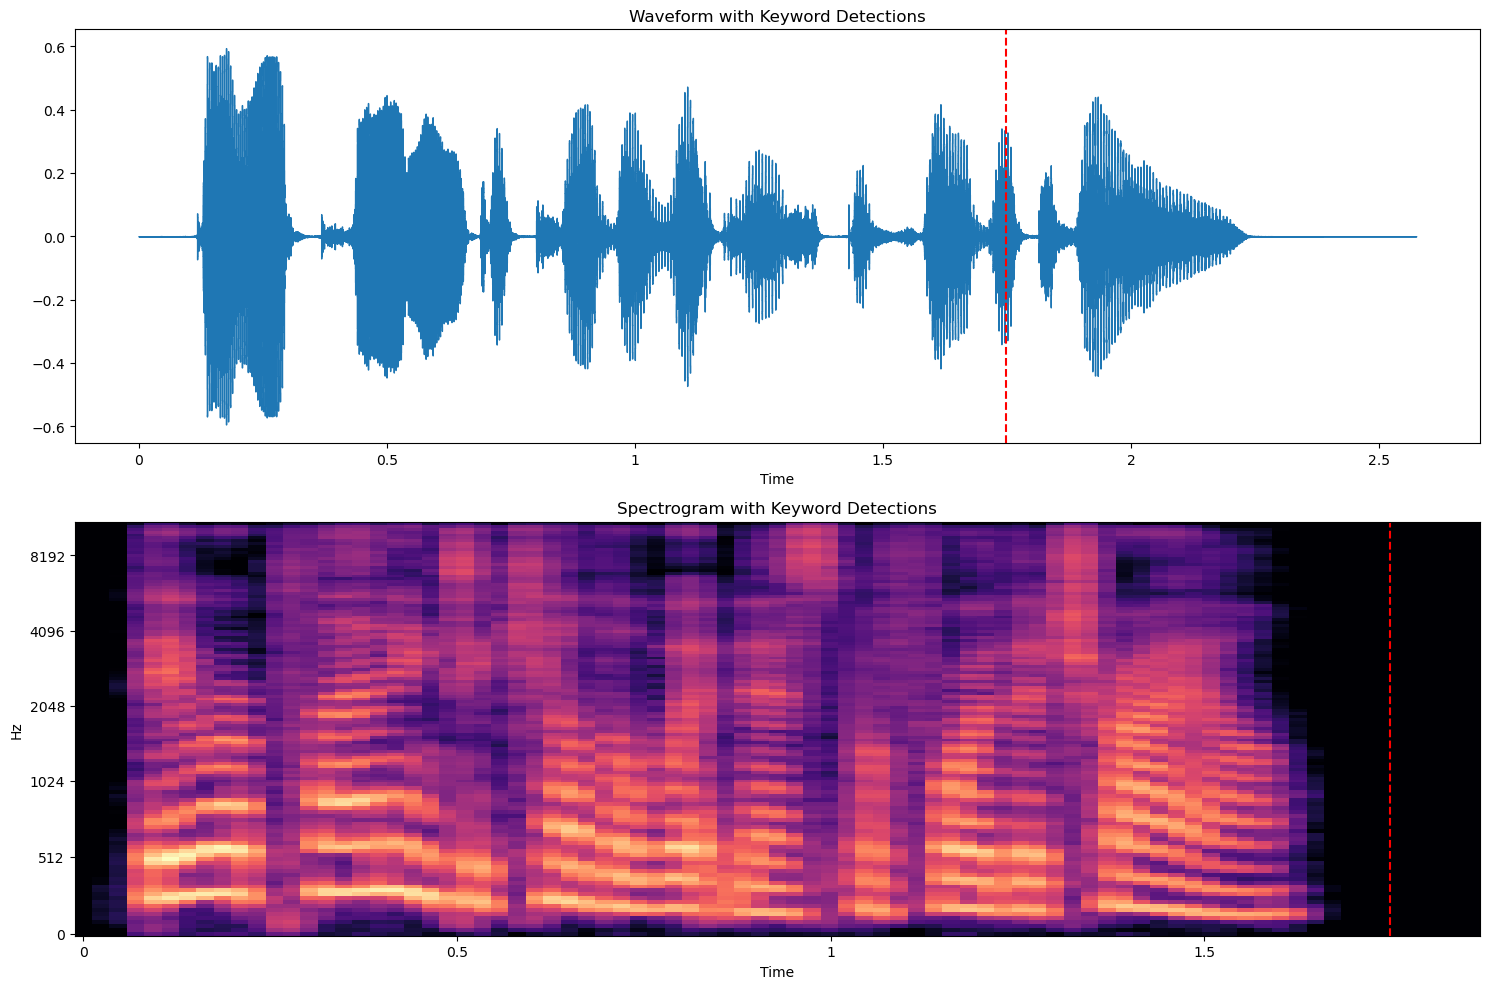

In [17]:
sentence_path = r"C:\Users\hp\Downloads\They were planning t.wav"
visualize_sentence_waveform(sentence_path)

detections = detect_keyword_in_file(sentence_path,r"C:\Users\hp\Downloads\kill.wav", threshold=2.1)
print(detections)
visualize_detections(sentence_path, detections)

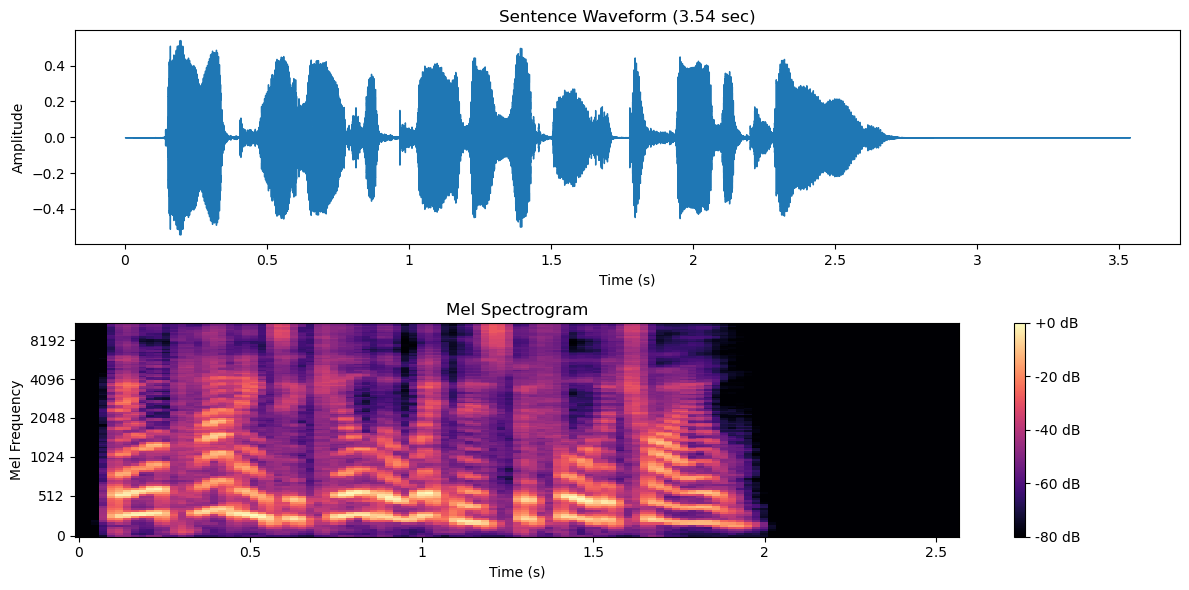

Audio duration: 3.54s | Feature shape: (111, 20)
Scanning |█████████████████████████████████-------| 83%
Keyword detected at 2.23s (distance: 2.0174)
Scanning |████████████████████████████████████████| 100%


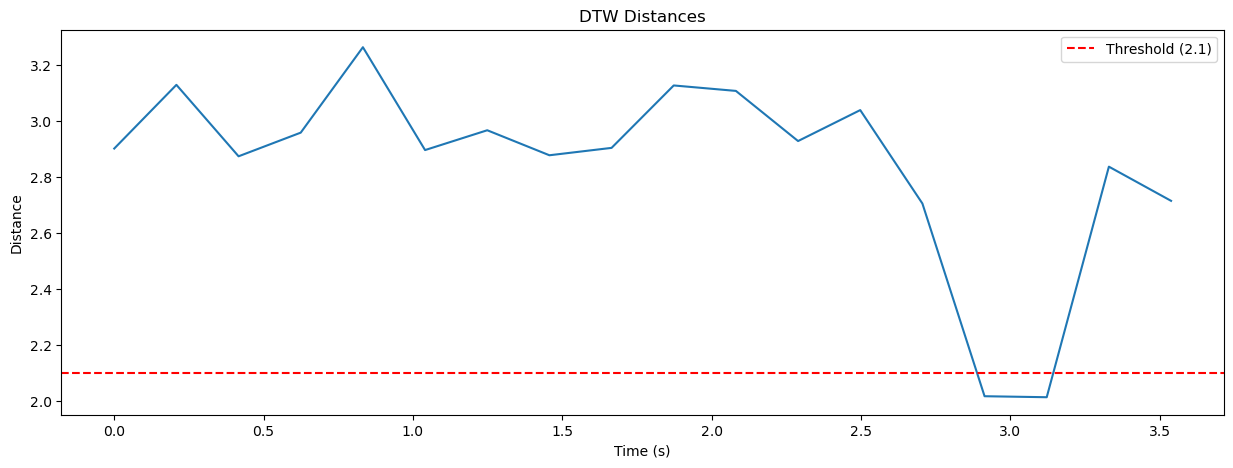

[2.230855855855856]


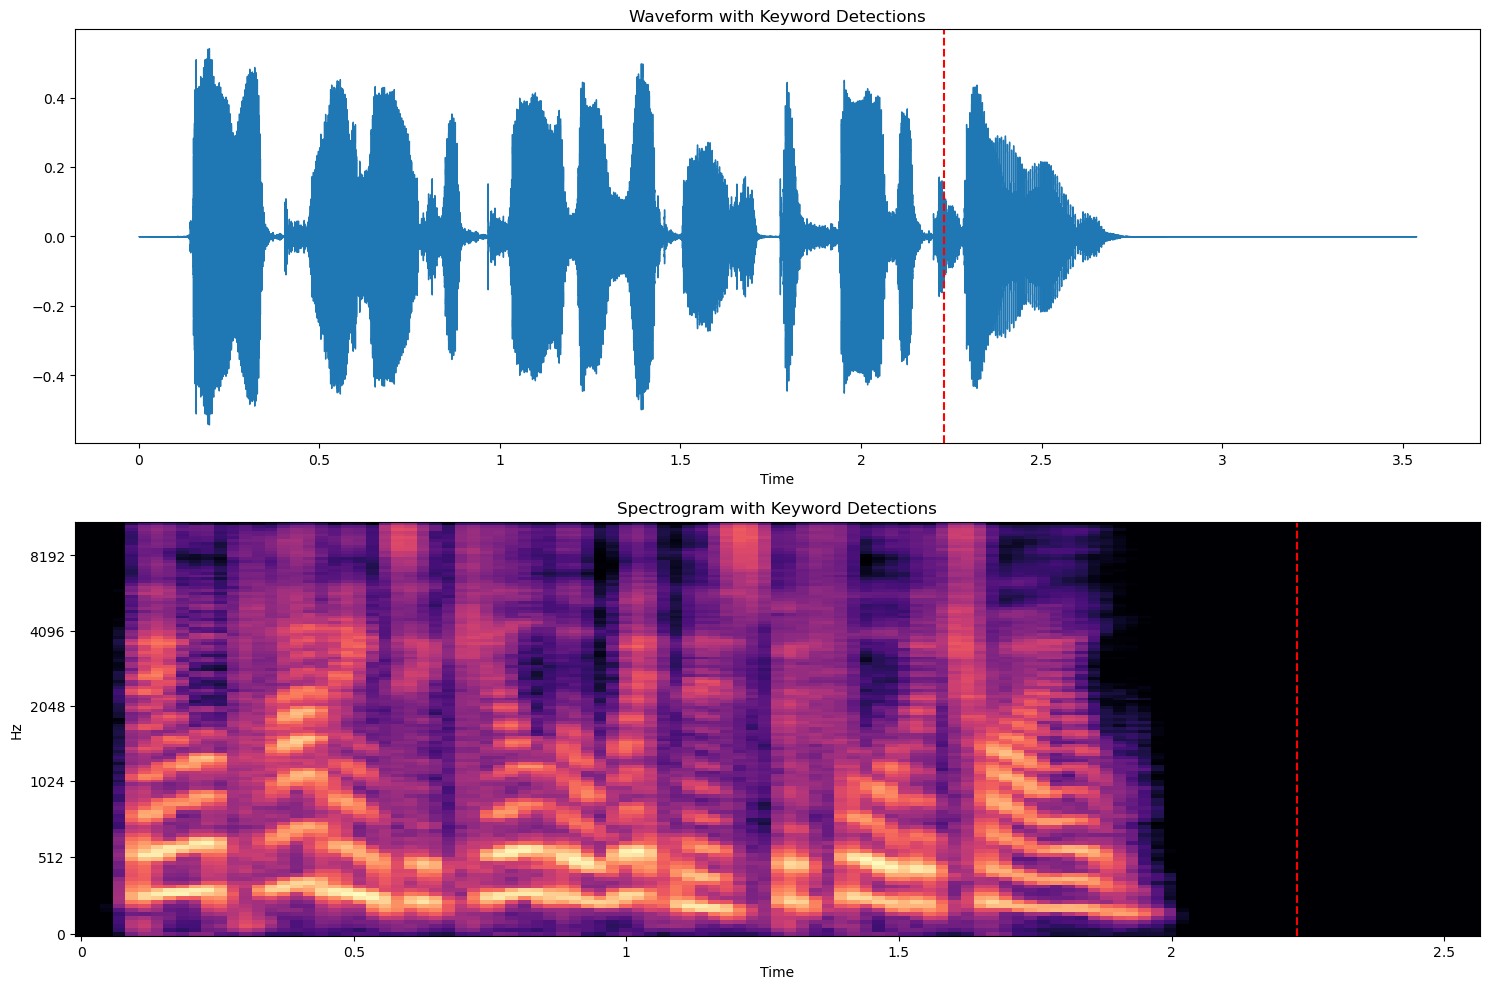

In [18]:
sentence_path = r"C:\Users\hp\Downloads\They were planning t (2).wav"
visualize_sentence_waveform(sentence_path)

detections = detect_keyword_in_file(sentence_path,r"C:\Users\hp\Downloads\kill.wav", threshold=2.1)
print(detections)
visualize_detections(sentence_path, detections)